In [2]:
%matplotlib inline

In [1]:
# coding: utf-8


import os
import numpy as np
import pickle as pkl
import argparse
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score, average_precision_score

from eval_helpers import top_k_infection_precision_recall
from helpers import load_cascades
from graph_helpers import load_graph_by_name



parser = argparse.ArgumentParser(description='')
parser.add_argument('-g', '--graph', help='graph name')
parser.add_argument('-c', '--cascade_pattern', help='graph name')

# args = parser.parse_args()

# graph_name = args.graph
graph_name = 'grqc'
cascade_pattern = 'grqc-s0.2-o0.1'

inf_proba_dirname = 'outputs/inf_probas/{}'.format(cascade_pattern)


g = load_graph_by_name(graph_name)

cascades = load_cascades('cascade/' + cascade_pattern)


methods = ['pagerank', 'random', 'entropy', 'prediction_error']




In [3]:
cascades = load_cascades('cascade/' + cascade_pattern)

scores_by_method = {}
for method in methods:
    scores_by_method[method] = []

c_paths = []  # track the order
for c_path, (obs, c) in tqdm(cascades):
    c_paths.append(c_path)
    infected = (c >= 0).nonzero()[0]    
    y_true = np.zeros((len(c), ))
    y_true[infected] = 1
    
    for method in methods:

        cid = os.path.basename(c_path).split('.')[0]
        inf_probas_path = os.path.join(
            inf_proba_dirname,
            method,
            '{}.pkl'.format(cid))
        inf_probas_list = pkl.load(open(inf_probas_path, 'rb'))

        scores = []
        for inf_probas in inf_probas_list:                    
            # score = roc_auc_score(y_true, inf_probas, average=None)
            # score = top_k_infection_precision_recall(g, inf_probas, c, obs, 65)[0]
            score = average_precision_score(y_true, inf_probas)
            scores.append(score)
#            y_pred = (inf_probas > 0.5).nonzero()[0]
#            y_pred
        scores_by_method[method].append(scores)

100it [00:51,  2.08it/s]


In [4]:
scores_3d = np.array([scores_by_method[m] for m in methods])

In [5]:
scores_3d.shape # method, rounds, queries

(4, 100, 100)

In [6]:
target_method_index = methods.index('prediction_error')

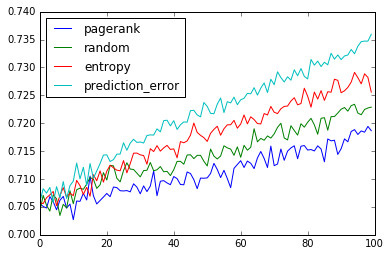

In [7]:
from matplotlib import pyplot as plt

plt.clf()
fig = plt.figure()
for method in methods:
    scores = np.array(scores_by_method[method], dtype=np.float32)
    mean_scores = np.median(scores, axis=0)
    # print(np.std(scores,axis=0))
    plt.plot(mean_scores)
    plt.hold(True)
plt.legend(methods, loc='best')

In [8]:
fig.savefig('figs/average_precision_score/{}.png'.format(graph_name))

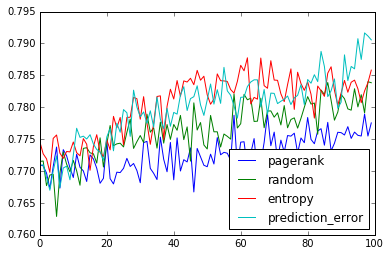

In [9]:
fig = plt.figure()

for scores in scores_3d[:, 0, :]:
    plt.plot(scores)
plt.legend(methods, loc='best')